In [1]:
import torch
from torch import nn

# ResNets & Model Fine-Tuning

In the **first part** of this lecture, we cover one of the current state-of-the-art neural network architectures for visual recognition, *ResNets*, introducded by He et al., https://arxiv.org/abs/1512.03385.

In the **second part**, we cover the topic of *model fine-tuning*, using a neural network pre-trained for a different task. In particular, we look at an approach that only modifies the final layer of a neural network (a second one would be to adjust all weights).

### Basic Residual Block

Lets implement a simple (**basic**) **residual block** of two layers of convolution, batch-normalization and ReLU activations (the second ReLU is delayed to after the addition).

![BasicBlock](BasicBlock.png "BasicBlock")


To realize this idea, we first create a function that returns a **3x3 convolution layer**, parametrized by the number of input and output channels, as well as the stride length. Note that the padding is set to 1, so in case of stride=1, we get output the same spatial dimension as the input.

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, 
                     out_planes, 
                     kernel_size=3, 
                     stride=stride,
                     padding=1, 
                     bias=False)

In [4]:
# Simple test
l = conv3x3(10,20,stride=1)
print(l(torch.randn(4,10,32,32)).size())

torch.Size([4, 20, 32, 32])


We are now ready to create a class that implementes the residual block.

In [6]:
class BasicBlock_v1(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock_v1, self).__init__()
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained), BN + ReLU
        """ 
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        """
        3x3 convolution inplanes->outplanes 
        (spatial size maintained) + BN
        """ 
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
    def forward(self, x):
        residual = x # save x 
    
        # conv->bn->relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # conv->bn
        out = self.conv2(out)
        out = self.bn2(out)

        # x + F(x) - this realizes the shortcut conn.
        out += residual
        out = self.relu(out) # final relu (see figure)

        return out

In [7]:
# Test input data, batch-size 4, 32 channels, spatial dim. 12x12 
x = torch.randn(4,64,12,12)

# Push this data through a basic block
bb = BasicBlock_v1(64,64)
print(bb(x).size())

torch.Size([4, 64, 12, 12])


Ok, so what if the stride is **not** chosen to be 1?

In [8]:
x = torch.randn(4,64,12,12)
try:
    bb = BasicBlock_v1(64, 64, stride=2)
    print(bb.size())
except:
    print('Error')

Error


This happens as the dimensions are not compatible at the $F(x)+x$ operation.  We can easily fix this by a **1x1 convolution** with appropriate stride, i.e., a projection operation on $x$.

In [10]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes, 
        out_planes, 
        kernel_size=1, 
        stride=stride, 
        bias=False)

In [11]:
class BasicBlock_v2(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_v2, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)        
        self.stride = stride
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
    
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        """
        At that point, we check if a downsampling needs to be 
        applied on x, such that F(x)+x can be computed.
        """
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)

        return out

**Note**: If we have multiple input channels, say 32, then the kernel is of size 32x1x1 and this kernel is applied with stride 1 over the full feature map. Mathematically, this corresponds to taking the dot product between the kernel and each feature in the feature map (i.e., again a 32x1x1 tensor).

In [13]:
# 1x1 convolution from 64 to 64 channels using a stride of 2
# This decreases the spatial size by a factor of 2 (obviously)!
down_fn = conv1x1(
    64,
    64,
    stride=2)

# Input is a tensor of size 4x64x12x12 (so 64 channels)
x = torch.randn(4,64,12,12)

bb = BasicBlock_v2(
    64,
    64,
    stride=2,
    downsample=down_fn)

print(bb(x).size()) # Voila!

torch.Size([4, 64, 6, 6])


### Bottleneck block

With our previous implementation, we can handle different strides. Next, we look at the **bottleneck** design of a residual block. We can resuse our function that returns a 1x1
convolution layer and our function that returns a 3x3 convolution layer.

![Bottleneck](BottleneckBlock.png "Bottleneck")



In [15]:
class Bottleneck(nn.Module):
    """
    The expansion factor controls the number of output 
    channels of the last 1x1 convolution layer.
    """
    expansion = 4  

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [16]:
# Lets try this

down_fn = conv1x1(256,256,stride=2)
x = torch.randn(4,256,12,12)
bb = Bottleneck(256,64,stride=2,downsample=down_fn)
print(bb(x).size())

torch.Size([4, 256, 6, 6])


### Actual ResNet implementation

With this in mind, we are now ready to actually look at the final ResNet-18/36/... architecture:

https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

Lets use a **pretrained** (on ImageNet-1000) ResNet-18 network.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

from torchvision.models import resnet18
from torchvision import transforms

from PIL import Image

In [19]:
model = resnet18(pretrained=True)

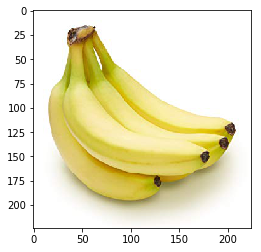

In [95]:
im = Image.open('banana.jpg')
plt.imshow(im.resize((224,224)))

The ResNet was trained on $224 \times 224$ images that were mean-subtracted and normalized by the standard deviation. So, in order to use this network on our own data, we have to resize an input image to $224 \times 224$, and subtract the dataset mean and divide by the standard deviation. Fortunately, the `torchvision` package allows us to do this easily.

In [96]:
# create a transform that (1) crops a center 224x224 patch, (2) converts the PIL image into
# a PyTorch tensor and (3) normalizes the image.
tr = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# Check
inp = tr(im).unsqueeze(0)
print(inp.size())

torch.Size([1, 3, 224, 224])


We are now ready to apply the model. We first set the model to *evaluation* mode (makes sure the BatchNorm parameters found during training are used).

In [97]:
model.eval()
out = model(inp)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [98]:
# Load ImageNet class names
import pickle
from urllib.request import urlopen
classes = pickle.load(
    urlopen(
        'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )

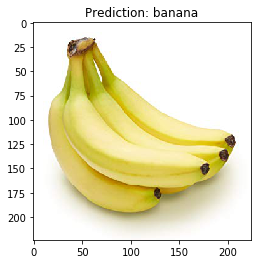

In [32]:
plt.imshow(im.resize((224,224)));
plt.title('Prediction: {}'.format(classes[out.argmax().item()]));

# Model fine-Tuning

Next, we discuss how to adjust a pre-trained ConvNet (e.g., a ResNet-18) to our a new problem. In particular, we take a ResNet-18, trained on ImageNet-1000 (from above), and fine-tune it to distinguish between *ants* and *bees*.

In [35]:
# First, we create a copy of our model; all the information, e.g., weights, etc., are stored
# in a dictionary, called the state dictionary, that is accessible via state_dict()
import copy
simp_model_state_dict = copy.deepcopy(model.state_dict())

In [36]:
# Now, we are ready to create a dataset from our ants/bees 
# image folder and instantiate a data loader using that dataset.
import torchvision

bees_ants = torchvision.datasets.ImageFolder('hymenoptera_data/train', transform=tr)
data_loader = torch.utils.data.DataLoader(bees_ants,
                                          batch_size=16, # use mini-batches of size 16
                                          shuffle=True,  # shuffle batches during training
                                          num_workers=1) # use one thread for loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


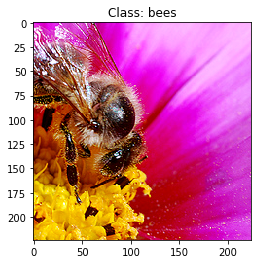

In [94]:
show_idx = 200

img = bees_ants[show_idx][0] # image
lab = bees_ants[show_idx][1] # label
# create a dictionary that allows us to easily convert 0/1 to bees/ants
idx_to_cls = {bees_ants.class_to_idx[k]: k for k in bees_ants.class_to_idx.keys()}

# Quick hack to invert the normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1.0/0.229, 1.0/0.224, 1.0/0.255]
)
inv_tensor = inv_normalize(img)
plt.imshow(inv_tensor.permute((1,2,0)).numpy());
plt.title('Class: {}'.format(idx_to_cls[bees_ants[show_idx][1]]));

Our method for fine-tuning will simply be to replace the last linear layer (fully-connected layer) of our model with a new one that fits our needs. Here, we have a **2-class problem**, so we need a linear layer with 2 outputs.

Further, we **do not** want to update all the model parameters, we just want the last layer to adapt to our 2-class problem. Hence, we set all other parameters to `requires_grad=False`. We will write a short function that does this for us.

In [73]:
def freeze_model(model):
    for param in model.parameters(): # iterate over all parameters and set requires_grad to False
        param.requires_grad = False  

Next, we replace the last layer of our model!

In [75]:
simp_model = resnet18()                           # instantiate ResNet-18 model
simp_model.load_state_dict(simp_model_state_dict) # load state-dict from pretrained model
freeze_model(simp_model)                          # freeze all model paramters
simp_model.fc = nn.Linear(simp_model.fc.in_features, 2) # replace FC layer
print(simp_model.fc.weight.requires_grad)

True


At this point, **only the replaced layer** will have `requires_grad=True` (default), so we can iterate over all parametes and collect those where `requires_grad` is `True`. We add these to a list.

In [76]:
params_to_update = []
for name,param in simp_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


We now have a pre-trained model with all layers, except the last one, frozen. Hence, we can start training. For that, we need an optimizer and a loss. We use SGD with **momentum** here and the commonly-used cross-entropy loss.

In [77]:
device = 'cuda'

opt = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

simp_model.to(device)
simp_model.train()

n_epochs = 10

for i in range(n_epochs):
    e_loss = 0
    
    for x,y in data_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        simp_model.zero_grad()    # zero gradients
        out = simp_model(x)       # forward pass
        loss = criterion(out, y)  # compute loss
        e_loss += loss.item()     # track loss (optional)
        loss.backward()           # compute gradients via backprop.
        opt.step()                # take an optimizer step

    print('Epoch {}: {:.4f}'.format(i, e_loss))
        


Epoch 0: 9.4676
Epoch 1: 6.0146
Epoch 2: 5.1075
Epoch 3: 3.7382
Epoch 4: 3.5849
Epoch 5: 2.7966
Epoch 6: 4.3430
Epoch 7: 2.6913
Epoch 8: 2.6315
Epoch 9: 2.8694


As a check to see if fine-tuning actually does a better job than simply training a ResNet-18 from scratch, lets just do this.

In [78]:
model_from_scratch = resnet18()
model_from_scratch.fc = nn.Linear(model_from_scratch.fc.in_features,2)
opt = torch.optim.SGD(model_from_scratch.parameters(), lr=0.001, momentum=0.9)

model_from_scratch.to(device)
model_from_scratch.train()

# Run over a couple of epochs
for i in range(30):
    e_loss = 0
    
    # Run over all batches of training data for ants/bees
    for x,y in data_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        model_from_scratch.zero_grad()    # zero gradients
        out = model_from_scratch(x)       # forward pass
        loss = criterion(out, y)  # compute loss
        e_loss += loss.item()     # track loss (optional)
        loss.backward()           # compute gradients via backprop.
        opt.step()                # take an optimizer step

    print('Epoch {}: {:.4f}'.format(i, e_loss))




Epoch 0: 11.4577
Epoch 1: 10.6614
Epoch 2: 10.1531
Epoch 3: 9.7518
Epoch 4: 10.6480
Epoch 5: 9.1941
Epoch 6: 8.2151
Epoch 7: 7.6011
Epoch 8: 8.2019
Epoch 9: 8.1919
Epoch 10: 7.1036
Epoch 11: 6.6958
Epoch 12: 5.9872
Epoch 13: 6.1392
Epoch 14: 5.9483
Epoch 15: 5.5017
Epoch 16: 5.2983
Epoch 17: 4.3709
Epoch 18: 3.4580
Epoch 19: 2.5945
Epoch 20: 2.6950
Epoch 21: 2.5325
Epoch 22: 1.6326
Epoch 23: 2.2177
Epoch 24: 2.3407
Epoch 25: 1.8288
Epoch 26: 2.7130
Epoch 27: 2.3746
Epoch 28: 2.1460
Epoch 29: 1.9717


In [79]:
bees_ants_val = torchvision.datasets.ImageFolder('hymenoptera_data/val',
                                            transform=tr)
data_loader_val = torch.utils.data.DataLoader(bees_ants_val,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=1)

In [82]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == y.data)

    print("Accuracy: ", float(running_corrects)/len(bees_ants_val)*100.0)

In [84]:
evaluate(simp_model, data_loader_val)
evaluate(model_from_scratch, data_loader_val)

Accuracy:  96.07843137254902
Accuracy:  74.50980392156863


We see that training from scratch on this rather small dataset, we heavily overfit to the data (training loss is comparable, but validation accuracy is far off). In case of fine-tuning, we only adjust the final layer (i.e., $512 \times 2$ parameters), whereas when training from scratch we adjust ...

In [93]:
n_params = 0
for p in model_from_scratch.parameters(): n_params+=p.numel()
print('Nr. of ResNet-18 model paramters: {}'.format(n_params))
print('Nr. of trainable parameters for finetuning {}'.format(simp_model.fc.weight.numel()+2))

Nr. of ResNet-18 model paramters: 11177538
Nr. of trainable parameters for finetuning 1026


Next week, we look in greater detail into some optimization details as, e.g., we have used momentum for SGD in this example, but we do not know yet what this really does!